# Notebook for statistical analysis of model training and performance eval
## Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime, timedelta

from agents import MinimaxAgent, RandomAgent, AvoidNextLossAgent, ModelAgent, NeuroevolutionAgent
from environment import ConnectFourEnv
from evaluation_func import EvaluationFunction

## Training performance evaluation
The goal is to visualize the training performance of each model in a graph regarding loss and average return since those metrics were collected.
### Preparing the dataframe

In [2]:
#creating the initial dictionary by grid and loading the train data
dfs = {}
train_data = pd.read_csv('./training_data.csv',index_col=None)

#splitting the training data by model training data
dfs['6by7'] = train_data[train_data['PATH'] == './weights/d6by7.h5']
dfs['8by9'] = train_data[train_data['PATH'] == './weights/d8by9.h5']
dfs['10by11'] = train_data[train_data['PATH'] == './weights/d10by11.h5']
dfs['12by13'] = train_data[train_data['PATH'] == './weights/d12by13.h5']

#making the epoch the index for each dataframe
dfs['6by7'].set_index('EPOCH')
dfs['8by9'].set_index('EPOCH')
dfs['10by11'].set_index('EPOCH')
dfs['12by13'].set_index('EPOCH')

dfs['6by7'].head()

,NAME,MODEL,DATE,EPOCH,EPSILON,AVERAGE LOSS,AVERAGE RETURN,PATH
70,202291706x72,dqn_6x7,2022-09-17 00:25:30.950582,1,0.844150,67.864143,20.834999,./weights/d6by7.h5
71,202291706x72,dqn_6x7,2022-09-17 00:30:03.655374,2,0.791767,71.923363,20.856874,./weights/d6by7.h5
72,202291706x7100,dqn_6x7,2022-09-17 00:55:55.927896,3,0.844150,70.225693,21.148750,./weights/d6by7.h5
73,202291706x7100,dqn_6x7,2022-09-17 01:00:20.662646,4,0.791767,68.359718,21.326876,./weights/d6by7.h5
74,202291706x7100,dqn_6x7,2022-09-17 01:04:42.994403,5,0.742633,69.293739,21.215626,./weights/d6by7.h5


### Visualization functions
We write a basic function for visualizing training process in matplotlib and save the figure at a desired path.

In [3]:
def visualize_progress(df, name : str, col_val : str, path : str, show=False):
    '''
    Function to show and also save a graph containing the reward over all episodes.
    :param epoch_returns (list): A list of acerage returns for n epochs (defined as 1000 training steps).
    '''

    x = np.arange(0, len(df))
    y = list(df[col_val])

    plt.style.use('dark_background')

    fig, ax = plt.subplots()
    ax.plot(x,y)

    ax.set_title(f'Training progress for model {name}')
    ax.set_ylabel(f' {col_val} per epoch')
    ax.set_xlabel('Epochs')

    fig.savefig(path)
    
    if show:
        plt.show()

We then run the function for each model we trained:

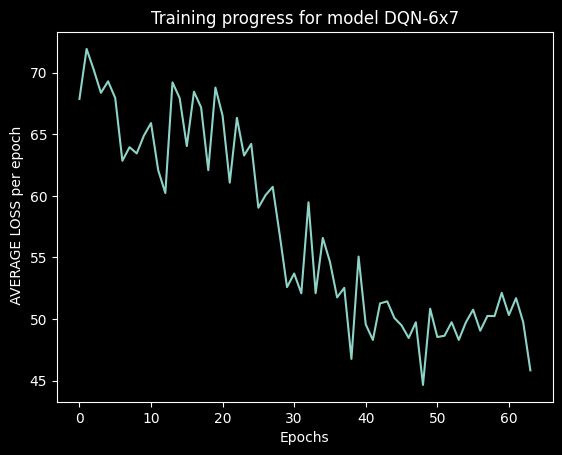

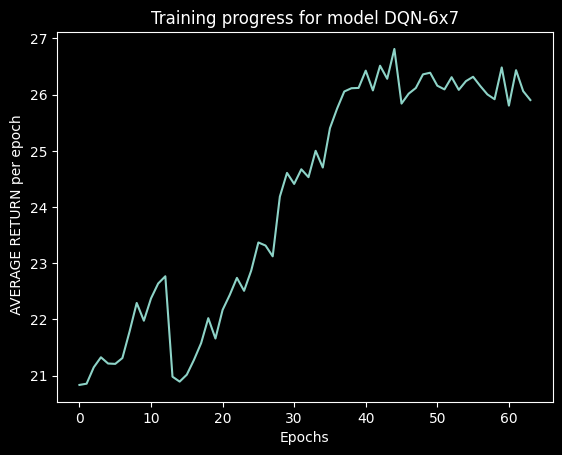

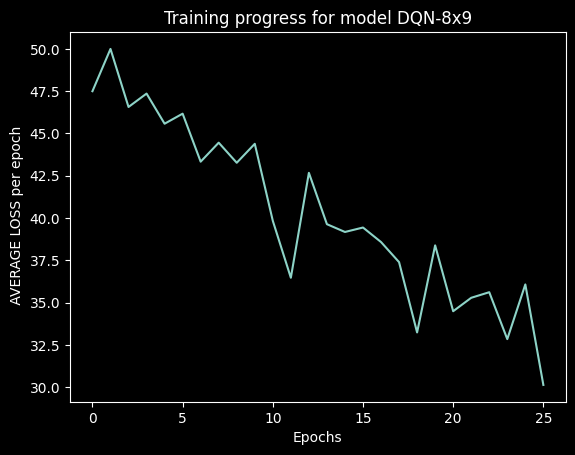

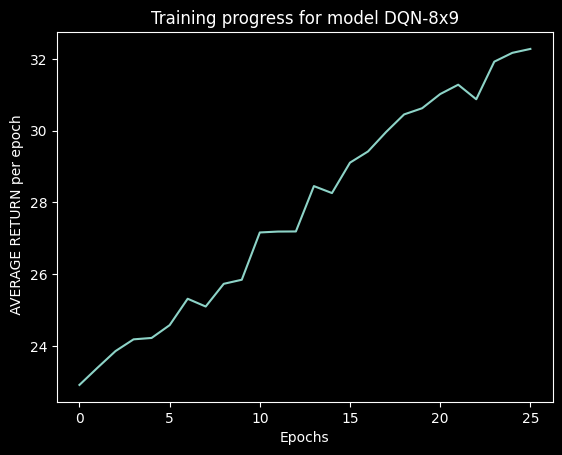

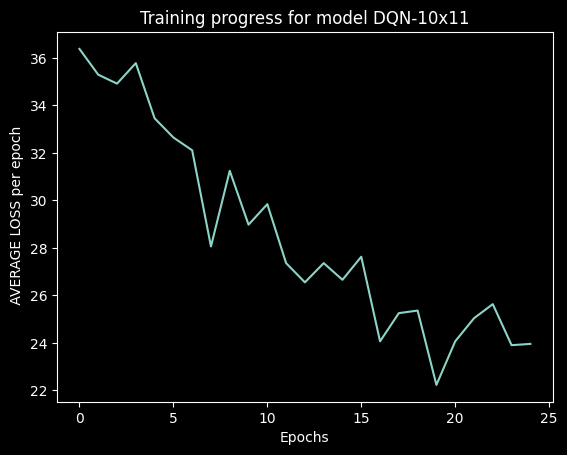

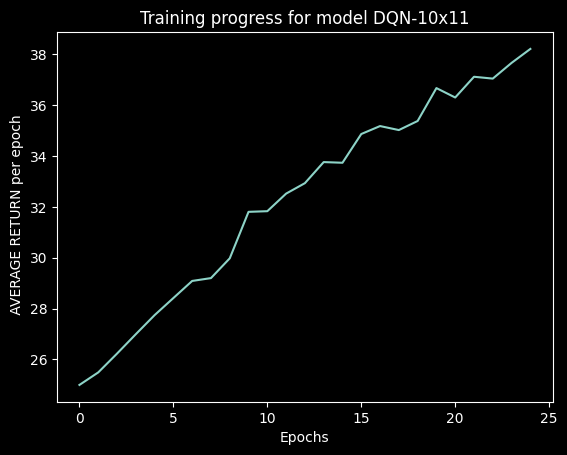

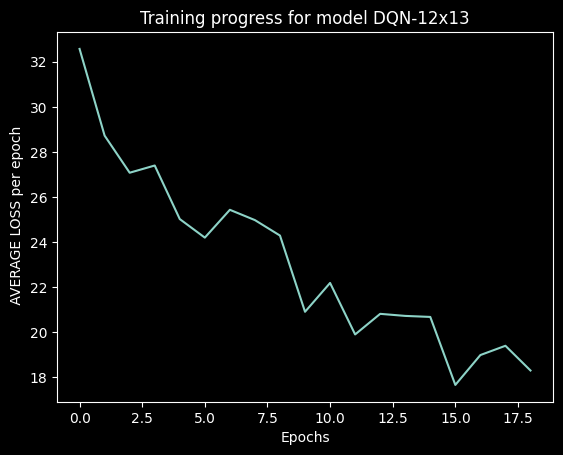

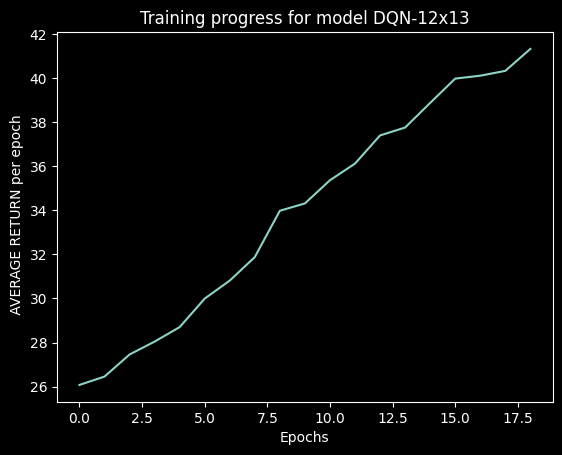

In [4]:
visualize_progress(dfs['6by7'], 'DQN-6x7', 'AVERAGE LOSS', './figures/6by7avgloss.png')
visualize_progress(dfs['6by7'], 'DQN-6x7', 'AVERAGE RETURN', './figures/6by7avgret.png')

visualize_progress(dfs['8by9'], 'DQN-8x9', 'AVERAGE LOSS', './figures/8by9avgloss.png')
visualize_progress(dfs['8by9'], 'DQN-8x9', 'AVERAGE RETURN', './figures/8by9avgret.png')

visualize_progress(dfs['10by11'], 'DQN-10x11', 'AVERAGE LOSS', './figures/10by11avgloss.png')
visualize_progress(dfs['10by11'], 'DQN-10x11', 'AVERAGE RETURN', './figures/10by11avgret.png')

visualize_progress(dfs['12by13'], 'DQN-12x13', 'AVERAGE LOSS', './figures/12by13avgloss.png')
visualize_progress(dfs['12by13'], 'DQN-12x13', 'AVERAGE RETURN', './figures/12by13avgret.png')

## Agent performance evaluation
Our goal is to evaluate the performance of each model against each other per grid size of the Environment.
If there is a significant advantage of one model over another based on statistics it can be called better.

### Agent initialization
We firstly initialize every agent we have.

In [5]:
minimax = MinimaxAgent()
random = RandomAgent()
lossavoid = AvoidNextLossAgent()

dqn = {}
dqn['6by7'] = ModelAgent('d6by7')
dqn['8by9'] = ModelAgent('d8by9')
dqn['10by11'] = ModelAgent('d10by11')
dqn['12by13'] = ModelAgent('d12by13')

neuroevo = NeuroevolutionAgent('Evolved_ANN.pickle')

### Writing the match functions and the pandas dataframe for storing the information

In [6]:
def match_agents(agent_a, agent_b, gridsize : tuple, playouts=100):
    '''
    Function for playout between two different agents on a Connect-Four grid of fixed size.
    Agents A and B will play against each other and statistics will be collected and stored in their object instance.
    Note that on uneven (even by index since it starts from 0) playouts A will be first to move and on even playouts B will have the first move.
    
    :param agent_a (): An agent who can play on the specified gridsize.
    :param agent_b (): An agent who can play on the specified gridsize.
    :param gridsize (tuple): A valid gridsize for the environment and agents, accepts (6,7), (8,9), (10,11), (12,13).
    :param playouts (int): The number of games to be played.
    '''
    
    env = ConnectFourEnv(gridsize)
    
    time_a = []
    time_b = []
    for i in tqdm(range(playouts),desc='Matches processed:'):
        env.reset() #reset environment once
        
        while not env.terminal:
            if (env.turn and (i % 2) == 0) or (not env.turn and (i % 2) == 1):
                starttime = datetime.now()
                action = agent_a.select_move(env)
                time_a += [(datetime.now()-starttime).microseconds*(10**-6)]
                env.step(action)
                
            elif (not env.turn and (i % 2) == 0) or (env.turn and (i % 2) == 1):
                starttime = datetime.now()
                action = agent_b.select_move(env)
                time_b += [(datetime.now()-starttime).microseconds*(10**-6)]
                env.step(action)
        
        #after each played match statistics of wins and time are gathered
        if (i % 2) == 0:
            if env.winner:
                agent_a.wins += 1
                agent_b.losses += 1
                
            else:
                agent_a.losses += 1
                agent_b.wins += 1
        else:
            if env.winner:
                agent_b.wins += 1
                agent_a.losses += 1
                
            else:
                agent_b.losses += 1
                agent_a.wins += 1
    
    #after every match was played the time statistics are added
    agent_a.average_speed = float(np.mean(time_a))
    agent_b.average_speed = float(np.mean(time_b))

### Now for each agent we can start to collect data and store it in a DataFrame

In [7]:
columns = ['AGENT A','AGENT B', 'GRID', 'A', 'B']
df = pd.DataFrame(columns=columns)
df

,AGENT A,AGENT B,GRID,A,B


In [8]:
name_for_idx = {0 : 'RandomAgent', 1 : 'AvoidNextLossAgent', 2 : 'MinimaxAgent', 3 : 'ModelAgent', 4 : 'NeuroevolutionAgent'}
for s_idx, gridsize in enumerate([(6, 7), (8, 9), (10, 11), (12, 13)]):
    for i, agent_a in enumerate([random, lossavoid, minimax, dqn, neuroevo]):
        for j, agent_b in enumerate([random, lossavoid, minimax, dqn, neuroevo]):
            if i != j and j > i and not (s_idx >= 1 and ((i == 4) or (j == 4))):
                print(f'Putting {name_for_idx[i]} vs {name_for_idx[j]} for grid size = {gridsize}:')
                
                if i == 3:
                    match_agents(agent_a[list(dqn.keys())[s_idx]], agent_b, gridsize)
                    appendix = pd.DataFrame([[name_for_idx[i],name_for_idx[j],str(gridsize),agent_a[list(dqn.keys())[s_idx]].wins,agent_b.wins]],columns=columns)
                    print(agent_a[list(dqn.keys())[s_idx]])
                    print(agent_b)
                    agent_a[list(dqn.keys())[s_idx]].reset()
                    agent_b.reset()
                    
                elif j == 3:
                    match_agents(agent_a, agent_b[list(dqn.keys())[s_idx]], gridsize)
                    appendix = pd.DataFrame([[name_for_idx[i],name_for_idx[j],str(gridsize),agent_a.wins,agent_b[list(dqn.keys())[s_idx]].wins]],columns=columns)
                    print(agent_a)
                    print(agent_b[list(dqn.keys())[s_idx]])
                    agent_a.reset()
                    agent_b[list(dqn.keys())[s_idx]].reset()
                    
                else:
                    match_agents(agent_a, agent_b, gridsize)
                    appendix = pd.DataFrame([[name_for_idx[i],name_for_idx[j],str(gridsize),agent_a.wins,agent_b.wins]],columns=columns)
                    print(agent_a)
                    print(agent_b)
                    agent_a.reset()
                    agent_b.reset()
                
                df = df.append(appendix)

Putting RandomAgent vs AvoidNextLossAgent for grid size = (6, 7):


Matches processed:: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 229.42it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (1, 4, 5) with avg speed 2.5949999999999997e-05 secs/move.
Agent performance (4, 1, 5) with avg speed 0.0006062727272727272 secs/move.
Putting RandomAgent vs MinimaxAgent for grid size = (6, 7):


Matches processed:: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (0, 5, 5) with avg speed 4.370588235294118e-05 secs/move.
Agent performance (5, 0, 5) with avg speed 0.29599200000000003 secs/move.
Putting RandomAgent vs ModelAgent for grid size = (6, 7):


Matches processed:: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 173.81it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (0, 5, 5) with avg speed 5.876470588235294e-05 secs/move.
Agent performance (5, 0, 5) with avg speed 0.0009434285714285714 secs/move.
Putting RandomAgent vs NeuroevolutionAgent for grid size = (6, 7):


Matches processed:: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 201.41it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (0, 5, 5) with avg speed 7.793749999999999e-05 secs/move.
Agent performance (5, 0, 5) with avg speed 0.00038816666666666665 secs/move.
Putting AvoidNextLossAgent vs MinimaxAgent for grid size = (6, 7):


Matches processed:: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.49s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (0, 5, 5) with avg speed 0.0006751794871794871 secs/move.
Agent performance (5, 0, 5) with avg speed 0.28881902325581393 secs/move.
Putting AvoidNextLossAgent vs ModelAgent for grid size = (6, 7):


Matches processed:: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 56.18it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (5, 0, 5) with avg speed 0.0007198399999999999 secs/move.
Agent performance (0, 5, 5) with avg speed 0.0008144444444444444 secs/move.
Putting AvoidNextLossAgent vs NeuroevolutionAgent for grid size = (6, 7):


Matches processed:: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 201.39it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (5, 0, 5) with avg speed 0.00059665 secs/move.
Agent performance (0, 5, 5) with avg speed 0.00023159999999999996 secs/move.
Putting MinimaxAgent vs ModelAgent for grid size = (6, 7):


Matches processed:: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.33s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (5, 0, 5) with avg speed 0.2903102 secs/move.
Agent performance (0, 5, 5) with avg speed 0.000836 secs/move.
Putting MinimaxAgent vs NeuroevolutionAgent for grid size = (6, 7):


Matches processed:: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (5, 0, 5) with avg speed 0.28793389999999996 secs/move.
Agent performance (0, 5, 5) with avg speed 0.00042966666666666663 secs/move.
Putting ModelAgent vs NeuroevolutionAgent for grid size = (6, 7):


Matches processed:: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 151.42it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (5, 0, 5) with avg speed 0.0010798000000000001 secs/move.
Agent performance (0, 5, 5) with avg speed 0.00039766666666666667 secs/move.
Putting RandomAgent vs AvoidNextLossAgent for grid size = (8, 9):


Matches processed:: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 201.61it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (0, 5, 5) with avg speed 3.05625e-05 secs/move.
Agent performance (5, 0, 5) with avg speed 0.00094155 secs/move.
Putting RandomAgent vs MinimaxAgent for grid size = (8, 9):


Matches processed:: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.45s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (0, 5, 5) with avg speed 6.2e-05 secs/move.
Agent performance (5, 0, 5) with avg speed 0.6125153999999999 secs/move.
Putting RandomAgent vs ModelAgent for grid size = (8, 9):


Matches processed:: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 148.24it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (0, 5, 5) with avg speed 5.2157894736842114e-05 secs/move.
Agent performance (5, 0, 5) with avg speed 0.0009056521739130435 secs/move.
Putting AvoidNextLossAgent vs MinimaxAgent for grid size = (8, 9):


Matches processed:: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:33<00:00,  6.66s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (0, 5, 5) with avg speed 0.00079678 secs/move.
Agent performance (5, 0, 5) with avg speed 0.6157157037037038 secs/move.
Putting AvoidNextLossAgent vs ModelAgent for grid size = (8, 9):


Matches processed:: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.84it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (5, 0, 5) with avg speed 0.0008653230769230768 secs/move.
Agent performance (0, 5, 5) with avg speed 0.0009598499999999999 secs/move.
Putting MinimaxAgent vs ModelAgent for grid size = (8, 9):


Matches processed:: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.18s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (5, 0, 5) with avg speed 0.6163620799999999 secs/move.
Agent performance (0, 5, 5) with avg speed 0.0009369555555555554 secs/move.
Putting RandomAgent vs AvoidNextLossAgent for grid size = (10, 11):


Matches processed:: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 150.46it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (0, 5, 5) with avg speed 0.00015587499999999998 secs/move.
Agent performance (5, 0, 5) with avg speed 0.0011650999999999999 secs/move.
Putting RandomAgent vs MinimaxAgent for grid size = (10, 11):


Matches processed:: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.30s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (0, 5, 5) with avg speed 4.3130434782608695e-05 secs/move.
Agent performance (5, 0, 5) with avg speed 0.1654881851851852 secs/move.
Putting RandomAgent vs ModelAgent for grid size = (10, 11):


Matches processed:: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 130.88it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (0, 5, 5) with avg speed 2.610526315789474e-05 secs/move.
Agent performance (5, 0, 5) with avg speed 0.0011354347826086953 secs/move.
Putting AvoidNextLossAgent vs MinimaxAgent for grid size = (10, 11):


Matches processed:: 100%|████████████████████████████████████████████████████████████████| 5/5 [01:17<00:00, 15.48s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (0, 5, 5) with avg speed 0.0010797868852459017 secs/move.
Agent performance (5, 0, 5) with avg speed 0.18893316923076922 secs/move.
Putting AvoidNextLossAgent vs ModelAgent for grid size = (10, 11):


Matches processed:: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.70it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (5, 0, 5) with avg speed 0.0011252374999999998 secs/move.
Agent performance (0, 5, 5) with avg speed 0.0011866666666666666 secs/move.
Putting MinimaxAgent vs ModelAgent for grid size = (10, 11):


Matches processed:: 100%|████████████████████████████████████████████████████████████████| 5/5 [01:09<00:00, 13.80s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (5, 0, 5) with avg speed 0.14834906666666664 secs/move.
Agent performance (0, 5, 5) with avg speed 0.001253109090909091 secs/move.
Putting RandomAgent vs AvoidNextLossAgent for grid size = (12, 13):


Matches processed:: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 94.14it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (0, 5, 5) with avg speed 8.61304347826087e-05 secs/move.
Agent performance (5, 0, 5) with avg speed 0.0013775185185185184 secs/move.
Putting RandomAgent vs MinimaxAgent for grid size = (12, 13):


Matches processed:: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.84s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (0, 5, 5) with avg speed 5.221052631578948e-05 secs/move.
Agent performance (5, 0, 5) with avg speed 0.7039846956521738 secs/move.
Putting RandomAgent vs ModelAgent for grid size = (12, 13):


Matches processed:: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 127.60it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (0, 5, 5) with avg speed 5.226315789473684e-05 secs/move.
Agent performance (5, 0, 5) with avg speed 0.001121 secs/move.
Putting AvoidNextLossAgent vs MinimaxAgent for grid size = (12, 13):


Matches processed:: 100%|████████████████████████████████████████████████████████████████| 5/5 [02:30<00:00, 30.14s/it]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (0, 5, 5) with avg speed 0.0012946388888888888 secs/move.
Agent performance (5, 0, 5) with avg speed 0.5858855657894736 secs/move.
Putting AvoidNextLossAgent vs ModelAgent for grid size = (12, 13):


Matches processed:: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 17.83it/s]
C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


Agent performance (5, 0, 5) with avg speed 0.0012262315789473685 secs/move.
Agent performance (0, 5, 5) with avg speed 0.001442311111111111 secs/move.
Putting MinimaxAgent vs ModelAgent for grid size = (12, 13):


Matches processed:: 100%|████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.09s/it]

Agent performance (5, 0, 5) with avg speed 0.7613954714285714 secs/move.
Agent performance (0, 5, 5) with avg speed 0.0013988461538461537 secs/move.



C:\Users\marlo\AppData\Local\Temp\ipykernel_8120\3963148097.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(appendix)


In [9]:
df.head()

,AGENT A,AGENT B,GRID,A,B
0,RandomAgent,AvoidNextLossAgent,"(6, 7)",1,4
0,RandomAgent,MinimaxAgent,"(6, 7)",0,5
0,RandomAgent,ModelAgent,"(6, 7)",0,5
0,RandomAgent,NeuroevolutionAgent,"(6, 7)",0,5
0,AvoidNextLossAgent,MinimaxAgent,"(6, 7)",0,5


In [10]:
df.to_csv('./performance_data.csv',index=None)

In [11]:
# ADD ANALYSIS FUNCTIONS HERE

In [12]:
# ADD VISUALIZATION FUNCTIONS HERE

In [13]:
# CALL VISUALIZATION AND ANALYSIS FUNCTIONS HERE